In [1]:
import tensorflow as tf
import torch

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

from kan import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import csv

from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuda


In [3]:
# read dataset
df = pd.read_csv("Dataset/bank_marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";")

In [4]:
# preprocessing steps for numerical and categorical data (replace output value, replace missing value, encode, scale)
# replace 'yes' with 1 and 'no' with 0
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

numeric_features = df.drop(["y"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

C:\Users\PC\AppData\Local\Temp\ipykernel_17384\4124601977.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


In [5]:
# undersampling
from sklearn.utils import resample

df_majority = df[df["y"] == 0]
df_minority = df[df["y"] == 1]

df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

df_undersampled = pd.concat([df_majority_undersampled, df_minority])

In [6]:
features = df_undersampled.drop(['y'], axis=1)
target = df_undersampled['y']

features = preprocessor.fit_transform(features)

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

In [8]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [9]:
torch.cuda.empty_cache()

In [10]:
st = time.time()

best_model = {'grid': 100, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", et-st)

train loss: 2.27e-01 | test loss: 2.25e-01 | reg: 1.04e+01 : 100%|█| 100/100 [17:17<00:00, 10.38s/it

Accuracy 0.9412715435028076 0.942582905292511
Duration 1037.8103835582733


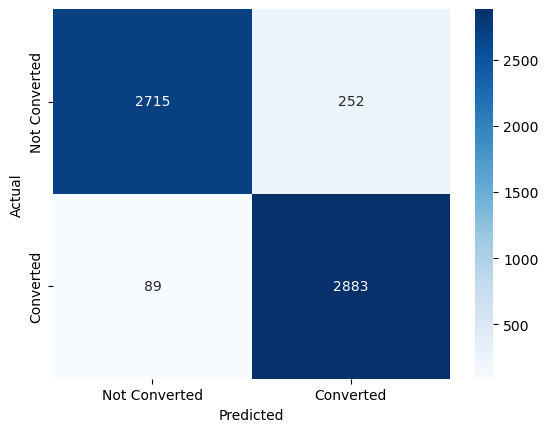

Accuracy: 0.942582926418589
Precision: 0.9196172248803828
Recall: 0.9700538358008075
F1 Score: 0.9441624365482234


In [11]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

# save to csv
filename = "2nd_KAN_performance.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Accuracy", accuracy])
    writer.writerow(["Precision", precision])
    writer.writerow(["Recall", recall])
    writer.writerow(["F1 Score", f1_score])
    writer.writerow(["Duration", et - st])

In [12]:
# cross validation
features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
target_tensor = torch.tensor(target.values.reshape(-1, 1), dtype=torch.float32).to(device)

kf = KFold(n_splits=5, shuffle=True, random_state=42) # play around random_state (run 10 times)
fold = 1
train_accs = []
test_accs = []
st = time.time()

best_model = {'grid': 100, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

for train_index, test_index in kf.split(features):
    print(f"Fold {fold}")
    
    X_train, X_test = features_tensor[train_index], features_tensor[test_index]
    y_train, y_test = target_tensor[train_index], target_tensor[test_index]
    
    train_input, test_input = X_train, X_test
    train_label, test_label = y_train, y_test
    
    dataset_fold = {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }
    
    model = KAN(width=[features_tensor.shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
    final_result = model.train(dataset_fold, 
                               opt="LBFGS", 
                               steps=best_model['step'], 
                               lamb=best_model['lamb'], 
                               lamb_entropy=best_model['lamb_entropy'], 
                               metrics=(train_acc, test_acc), 
                               device=device)
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]
    
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)
    
    print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    
    fold += 1

et = time.time()
avg_train_acc = np.mean(train_accs)
avg_test_acc = np.mean(test_accs)
print(f"Average Training Accuracy: {avg_train_acc}, Average Test Accuracy: {avg_test_acc}")
print(f"Total Time taken: {et - st} seconds")

avg_train_std = np.std(train_accs)
avg_test_std = np.std(test_accs)
print(f"Average Training std dev: {avg_train_std}, Average Test std dev: {avg_test_std}")

Fold 1


train loss: 2.28e-01 | test loss: 3.36e-01 | reg: 1.08e+01 : 100%|█| 100/100 [17:34<00:00, 10.55s/it


Train Accuracy: 0.9348060488700867, Test Accuracy: 0.9383734464645386
Fold 2


train loss: 2.26e-01 | test loss: 3.53e-01 | reg: 1.01e+01 : 100%|█| 100/100 [17:22<00:00, 10.43s/it


Train Accuracy: 0.9183728694915771, Test Accuracy: 0.9196833968162537
Fold 3


train loss: 2.23e-01 | test loss: 3.44e-01 | reg: 1.12e+01 : 100%|█| 100/100 [17:36<00:00, 10.56s/it


Train Accuracy: 0.9162176847457886, Test Accuracy: 0.9158107042312622
Fold 4


train loss: 2.29e-01 | test loss: 3.43e-01 | reg: 1.02e+01 : 100%|█| 100/100 [17:36<00:00, 10.56s/it


Train Accuracy: 0.9170258641242981, Test Accuracy: 0.9166526198387146
Fold 5


train loss: 2.30e-01 | test loss: 3.42e-01 | reg: 1.04e+01 : 100%|█| 100/100 [17:38<00:00, 10.58s/it

Train Accuracy: 0.9170258641242981, Test Accuracy: 0.9215355515480042
Average Training Accuracy: 0.9206896662712097, Average Test Accuracy: 0.9224111437797546
Total Time taken: 5268.342932701111 seconds
Average Training std dev: 0.007092042246111176, Average Test std dev: 0.008242921478052369


In [13]:
# save to csv
filename = "2nd_std_dev.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Fold", "Train", "Test"])
    writer.writerow(["1", train_accs[0], test_accs[0]])
    writer.writerow(["2", train_accs[1], test_accs[1]])
    writer.writerow(["3", train_accs[2], test_accs[2]])
    writer.writerow(["4", train_accs[3], test_accs[3]])
    writer.writerow(["5", train_accs[4], test_accs[4]])
    writer.writerow(["Avg Acc", avg_train_acc, avg_test_acc])
    writer.writerow(["Avg Std Dev", avg_train_std, avg_test_std])
    writer.writerow(["Duration", et - st])

In [14]:
# feature selection
numeric_features = df_undersampled.drop(["y"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df_undersampled.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df_undersampled)
target = df_undersampled['y']

feature_names = preprocessor.get_feature_names_out(input_features=df_undersampled.columns)
features = pd.DataFrame(features, columns=feature_names)

def feature_selection(X, y, criteria, k):
    selector = SelectKBest(criteria, k=k).fit(X, y)
    selected_columns = X.columns[selector.get_support()]
    X = X[selected_columns]
    return X

new_X = feature_selection(features, target, mutual_info_classif, 10)
print("\nmutual_info_classif : \n", new_X.columns)


mutual_info_classif : 
 Index(['num__duration', 'num__pdays', 'num__previous', 'num__emp.var.rate',
       'num__cons.price.idx', 'num__cons.conf.idx', 'num__euribor3m',
       'num__nr.employed', 'cat__month', 'cat__poutcome'],
      dtype='object')


In [15]:
# if use mutual_info_classif
torch.cuda.empty_cache()
new_features = df_undersampled[['age', 'duration', 'pdays', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'month', 'poutcome']]
new_target = df_undersampled['y']

numerical_cols = new_features.select_dtypes(exclude=['object']).columns
categorical_cols = new_features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

new_features = preprocessor.fit_transform(new_features)

X_train, X_temp, y_train, y_temp = train_test_split(new_features, new_target, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

st = time.time()

best_model = {'grid': 100, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", et-st)

train loss: 2.47e-01 | test loss: 2.45e-01 | reg: 1.31e+00 : 100%|█| 100/100 [03:34<00:00,  2.15s/it

Accuracy 0.9210668206214905 0.9222090840339661
Duration 214.8204743862152


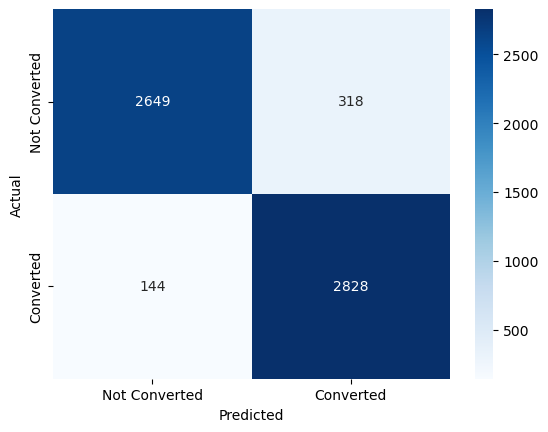

Accuracy: 0.9222091261155076
Precision: 0.8989192625556262
Recall: 0.9515477792732167
F1 Score: 0.9244851258581236


In [16]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

# save to csv
filename = "feature_selection_performance.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Accuracy", accuracy])
    writer.writerow(["Precision", precision])
    writer.writerow(["Recall", recall])
    writer.writerow(["F1 Score", f1_score])
    writer.writerow(["Duration", et - st])

In [17]:
# cross validation of feature selection
features_tensor = torch.tensor(new_features, dtype=torch.float32).to(device)
target_tensor = torch.tensor(new_target.values.reshape(-1, 1), dtype=torch.float32).to(device)

kf = KFold(n_splits=5, shuffle=True, random_state=42) # play around random_state (run 10 times)
fold = 1
train_accs = []
test_accs = []
st = time.time()

best_model = {'grid': 100, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

for train_index, test_index in kf.split(features):
    print(f"Fold {fold}")
    
    X_train, X_test = features_tensor[train_index], features_tensor[test_index]
    y_train, y_test = target_tensor[train_index], target_tensor[test_index]
    
    train_input, test_input = X_train, X_test
    train_label, test_label = y_train, y_test
    
    dataset_fold = {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }
    
    model = KAN(width=[features_tensor.shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
    final_result = model.train(dataset_fold, 
                               opt="LBFGS", 
                               steps=best_model['step'], 
                               lamb=best_model['lamb'], 
                               lamb_entropy=best_model['lamb_entropy'], 
                               metrics=(train_acc, test_acc), 
                               device=device)
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]
    
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)
    
    print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    
    fold += 1

et = time.time()
avg_train_acc = np.mean(train_accs)
avg_test_acc = np.mean(test_accs)
print(f"Average Training Accuracy: {avg_train_acc}, Average Test Accuracy: {avg_test_acc}")
print(f"Total Time taken: {et - st} seconds")

avg_train_std = np.std(train_accs)
avg_test_std = np.std(test_accs)
print(f"Average Training std dev: {avg_train_std}, Average Test std dev: {avg_test_std}")

Fold 1


train loss: 2.50e-01 | test loss: 3.20e-01 | reg: 1.47e+00 : 100%|█| 100/100 [03:37<00:00,  2.17s/it


Train Accuracy: 0.9168911576271057, Test Accuracy: 0.919178307056427
Fold 2


train loss: 2.45e-01 | test loss: 3.29e-01 | reg: 1.54e+00 : 100%|█| 100/100 [03:35<00:00,  2.15s/it


Train Accuracy: 0.9086745381355286, Test Accuracy: 0.9126115441322327
Fold 3


train loss: 2.52e-01 | test loss: 3.26e-01 | reg: 1.35e+00 : 100%|█| 100/100 [03:34<00:00,  2.14s/it


Train Accuracy: 0.9058458805084229, Test Accuracy: 0.9082337021827698
Fold 4


train loss: 2.44e-01 | test loss: 3.26e-01 | reg: 1.43e+00 : 100%|█| 100/100 [03:34<00:00,  2.14s/it


Train Accuracy: 0.9102909564971924, Test Accuracy: 0.9114328622817993
Fold 5


train loss: 2.53e-01 | test loss: 3.16e-01 | reg: 1.23e+00 : 100%|█| 100/100 [03:35<00:00,  2.15s/it

Train Accuracy: 0.9086745381355286, Test Accuracy: 0.9100858569145203
Average Training Accuracy: 0.9100754141807557, Average Test Accuracy: 0.9123084545135498
Total Time taken: 1076.2966344356537 seconds
Average Training std dev: 0.0036963408849893125, Average Test std dev: 0.0037308697559293217


In [18]:
# save to csv
import csv

filename = "fs_std_dev.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Fold", "Train", "Test"])
    writer.writerow(["1", train_accs[0], test_accs[0]])
    writer.writerow(["2", train_accs[1], test_accs[1]])
    writer.writerow(["3", train_accs[2], test_accs[2]])
    writer.writerow(["4", train_accs[3], test_accs[3]])
    writer.writerow(["5", train_accs[4], test_accs[4]])
    writer.writerow(["Avg Acc", avg_train_acc, avg_test_acc])
    writer.writerow(["Avg Std Dev", avg_train_std, avg_test_std])
    writer.writerow(["Duration", et - st])